In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

In [20]:
xls = pd.ExcelFile('online_retail_II.xlsx')
df1 = pd.read_excel(xls, 'Year 2009-2010')
df2 = pd.read_excel(xls, 'Year 2010-2011')

In [21]:
df_all = pd.concat([df1, df2], ignore_index=True)
df_all.shape

(1067371, 8)

In [23]:
cancelled_mask = df_all['Invoice'].str.startswith('C', na=False)
df_cancelled = df_all[cancelled_mask]
df = df_all[~cancelled_mask]
print(df_cancelled.shape)
print(df.shape)

(19494, 8)
(1047877, 8)


In [24]:
# https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

In [25]:
df = df[df['Description'] == 'WORLD WAR 2 GLIDERS ASSTD DESIGNS']
df = df.drop(['StockCode', 'Description', 'Customer ID', 'Country', 'Invoice'], axis=1)
df

,Quantity,InvoiceDate,Price
1309,48,2009-12-01 12:57:00,0.21
3548,288,2009-12-02 10:58:00,0.18
4192,3,2009-12-02 12:32:00,0.21
4531,48,2009-12-02 13:20:00,0.21
4543,96,2009-12-02 13:23:00,0.21
...,...,...,...
1060258,48,2011-12-07 15:02:00,0.29
1063701,48,2011-12-08 13:46:00,0.29
1064307,288,2011-12-08 15:03:00,0.21
1065828,48,2011-12-09 08:59:00,0.29


In [26]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate).dt.strftime('%Y-%m-%d')
df = df.groupby('InvoiceDate').sum().reset_index()
df = df.sort_values('InvoiceDate').rename(columns={'InvoiceDate': 'date', 'Quantity': 'y'})
df = df.set_index('date')
df


,y,Price
date,,
2009-12-01,48,0.21
2009-12-02,435,0.81
2009-12-03,56,0.63
2009-12-04,144,0.42
2009-12-05,48,0.21
...,...,...
2011-12-05,205,1.50
2011-12-06,243,1.79
2011-12-07,240,0.87


In [27]:
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


Train dates : 2009-12-01 --- 2011-11-15  (n=450)
Test dates  : 2011-11-16 --- 2011-12-09  (n=20)


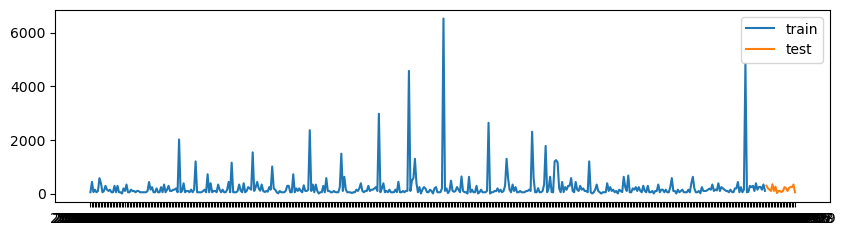

In [31]:
# The last steps data points are used as the test set to evaluate the precitive capacity of the model
steps = 20
data_train = df[:-steps]
data_test  = df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(10, 2.5))
# data_train['y'].plot(ax=ax, label='train')
# data_test['y'].plot(ax=ax, label='test')
ax.plot(data_train.index, data_train.y, label='train')
ax.plot(data_test.index, data_test.y, label='test')
ax.legend()

### Recursive Autoregressive Forecast

In [33]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [39]:
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=42),
    lags=10
    )

forecaster.fit(y=data_train['y'])
forecaster

c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packages\skforecast\utils\utils.py:798: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packages\skforecast\utils\utils.py:798: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 449] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-21 16:45:34 
Last fit date: 2023-10-21 16:45:34 
Skforecast version: 0.10.1 
Python version: 3.11.4 
Forecaster id: None 

In [42]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=20)
predictions.head(5)

c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packages\skforecast\utils\utils.py:860: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


10    164.93
11    143.73
12    303.94
13    186.39
14    168.46
Name: pred, dtype: float64

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


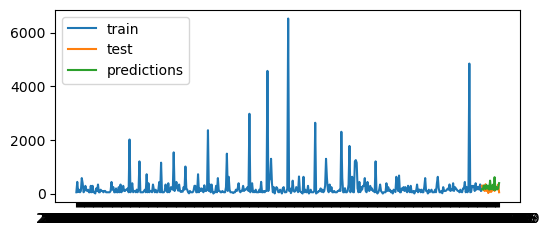

In [43]:
fig, ax = plt.subplots(figsize=(6, 2.5))
# data_train['y'].plot(ax=ax, label='train')
# data_test['y'].plot(ax=ax, label='test')
ax.plot(data_train.index, data_train.y, label='train')
ax.plot(data_test.index, data_test.y, label='test')
ax.plot(data_test.index, predictions, label='predictions')
ax.legend();

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

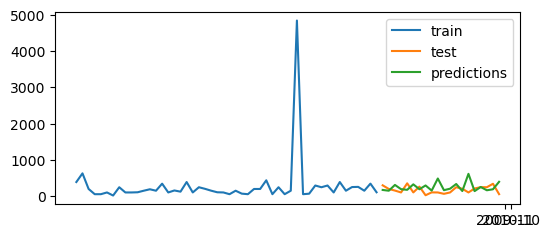

In [66]:
fig, ax = plt.subplots(figsize=(6, 2.5))
# data_train['y'].plot(ax=ax, label='train')
# data_test['y'].plot(ax=ax, label='test')
ax.plot(data_train.index[-50:], data_train.y[-50:], label='train')
ax.plot(data_test.index, data_test.y, label='test')
ax.plot(data_test.index, predictions, label='predictions')
# ax.get_xaxis().set_visible(False)
ax.set_xticks(['2009-11', '2010-10'])
ax.legend();

In [68]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 40612.303525


In [72]:
# Final Model
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['y'])

c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packages\skforecast\utils\utils.py:798: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packages\skforecast\utils\utils.py:798: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


In [73]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=20)

c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packages\skforecast\utils\utils.py:860: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

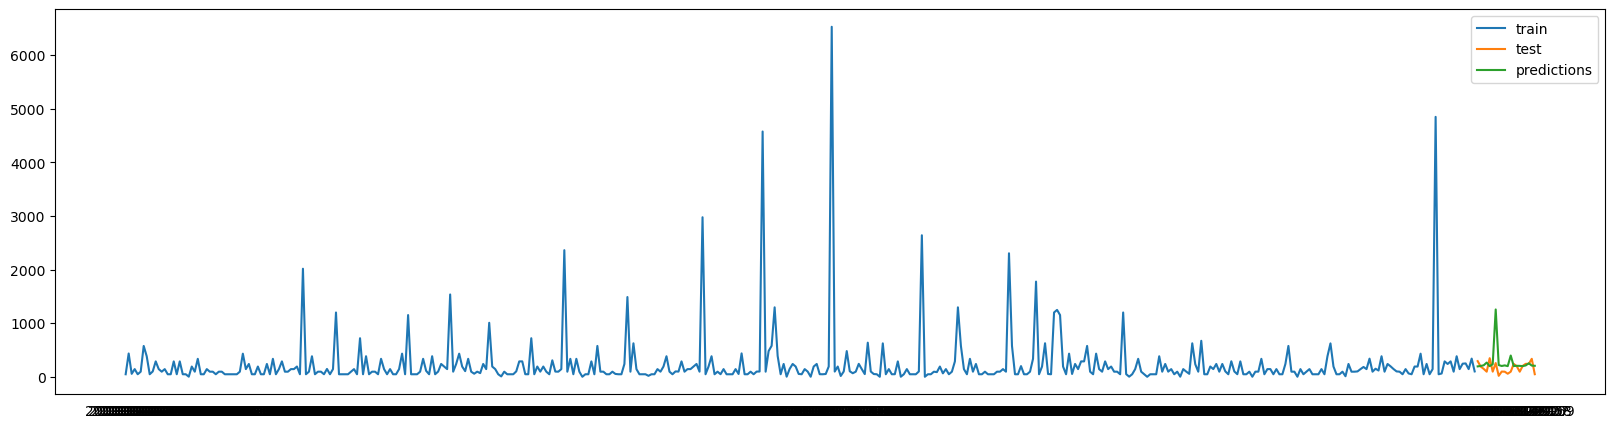

In [76]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 5))
# data_train['y'].plot(ax=ax, label='train')
# data_test['y'].plot(ax=ax, label='test')
# predictions.plot(ax=ax, label='predictions')
ax.plot(data_train.index, data_train.y, label='train')
ax.plot(data_test.index, data_test.y, label='test')
ax.plot(data_test.index, predictions, label='predictions')
ax.legend()
plt.tick_params(bottom=False)

In [75]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 65679.3570167759


## Vector AutoRegressive Model

Considering both price and quantity to predict

In [153]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.statespace.varmax import VARMAX
import math

In [82]:
df = df.rename(columns={'y': 'Quantity'})

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


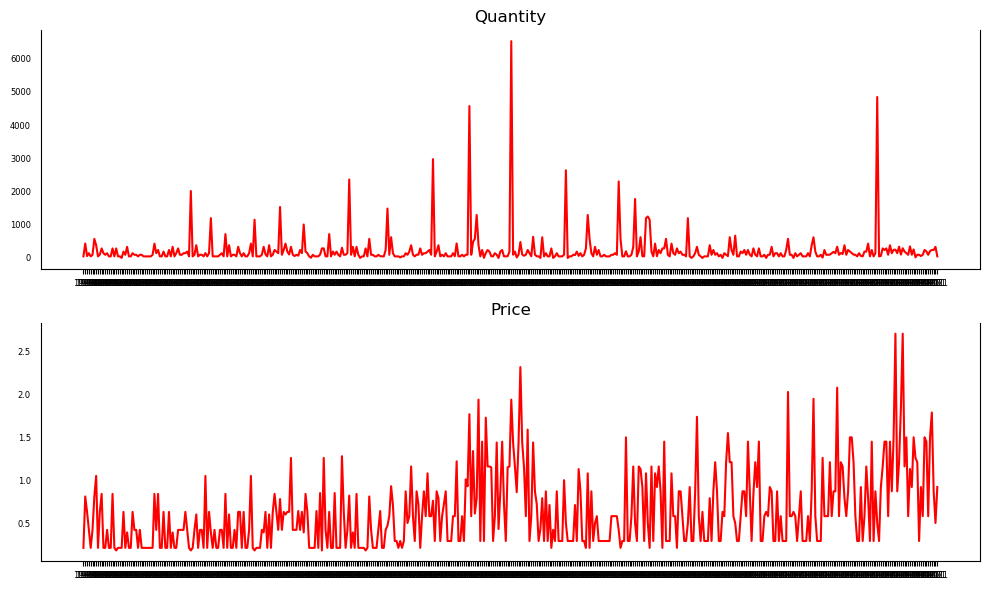

In [92]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    formatter = mdates.DateFormatter("%Y")
    ax.plot(data, color='red')
    ax.set_title(df.columns[i])
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()

In [103]:
def calc_adfuller(col):
    ad_fuller_res = adfuller(df[col]) #.diff()[n:]
    print(f"ADF Statistics: {ad_fuller_res[0]}")
    print(f'p-value: {ad_fuller_res[1]}')

In [105]:
calc_adfuller('Quantity')
calc_adfuller('Price')

ADF Statistics: -22.00439469468675
p-value: 0.0
ADF Statistics: -3.285027683350277
p-value: 0.015561147498945528


P-value for both columns are less than 0.05 which means the data is stationary

### Granger Causality Test

Granger causality test shows that if a time series causes another one. If time series x granger causes time series y, then we can model them together. That actually helps with the better predition. However, if two times series are completly independent, then it is best to model them separately since having both of them in the system not only adds nothing to the outcome but also hurts the performance of the model.

In [127]:
print('Qauntity causes Price?\n')
granger_1 = grangercausalitytests(df[['Price', 'Quantity']], 20)

Qauntity causes Price?


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4136  , p=0.1210  , df_denom=466, df_num=1
ssr based chi2 test:   chi2=2.4292  , p=0.1191  , df=1
likelihood ratio test: chi2=2.4229  , p=0.1196  , df=1
parameter F test:         F=2.4136  , p=0.1210  , df_denom=466, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1846  , p=0.3068  , df_denom=463, df_num=2
ssr based chi2 test:   chi2=2.3947  , p=0.3020  , df=2
likelihood ratio test: chi2=2.3886  , p=0.3029  , df=2
parameter F test:         F=1.1846  , p=0.3068  , df_denom=463, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6700  , p=0.5708  , df_denom=460, df_num=3
ssr based chi2 test:   chi2=2.0405  , p=0.5641  , df=3
likelihood ratio test: chi2=2.0360  , p=0.5650  , df=3
parameter F test:         F=0.6700  , p=0.5708  , df_denom=460, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:       

In [125]:
print("Price causes Quantity?\n")
granger_2 = grangercausalitytests(df[['Quantity', 'Price']], 20)

Price causes Quantity?


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5967  , p=0.2070  , df_denom=466, df_num=1
ssr based chi2 test:   chi2=1.6070  , p=0.2049  , df=1
likelihood ratio test: chi2=1.6042  , p=0.2053  , df=1
parameter F test:         F=1.5967  , p=0.2070  , df_denom=466, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8167  , p=0.4425  , df_denom=463, df_num=2
ssr based chi2 test:   chi2=1.6510  , p=0.4380  , df=2
likelihood ratio test: chi2=1.6481  , p=0.4387  , df=2
parameter F test:         F=0.8167  , p=0.4425  , df_denom=463, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5660  , p=0.6377  , df_denom=460, df_num=3
ssr based chi2 test:   chi2=1.7239  , p=0.6316  , df=3
likelihood ratio test: chi2=1.7207  , p=0.6323  , df=3
parameter F test:         F=0.5660  , p=0.6377  , df_denom=460, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:       

In [129]:
steps = 12
train_df = df[:-steps]
test_df = df[-steps:]

In [130]:
model = VAR(train_df)
sorted_order = model.select_order(maxlags=25)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        10.93       10.94   5.561e+04       10.93
1        10.84      10.90*   5.123e+04       10.87
2        10.81       10.90   4.946e+04      10.85*
3        10.81       10.94   4.936e+04       10.86
4        10.79       10.96   4.862e+04       10.86
5        10.77       10.97   4.741e+04       10.85
6        10.76       11.01   4.717e+04       10.86
7       10.74*       11.02  4.607e+04*       10.85
8        10.75       11.07   4.644e+04       10.87
9        10.76       11.11   4.696e+04       10.90
10       10.75       11.14   4.643e+04       10.90
11       10.76       11.19   4.721e+04       10.93
12       10.78       11.25   4.795e+04       10.96
13       10.79       11.29   4.834e+04       10.99
14       10.79       11.34   4.868e+04       11.01
15       10.79       11.37   4.862e+04       11.02
16       10.80       11.42   4.

c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


According to the summary of the sorted order and the result of AIC, lag 7 would be a good choice in this case.

In [135]:
var_model = VARMAX(train_df, order=(22, 0), enforce_stationarity=True)
fitted_model = var_model.fit(dis=False)
print(fitted_model.summary())

c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.
  warnings.warn(
c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Statespace Model Results                            
Dep. Variable:     ['Quantity', 'Price']   No. Observations:                  458
Model:                           VAR(22)   Log Likelihood               -3672.849
                             + intercept   AIC                           7531.699
Date:                   Sat, 21 Oct 2023   BIC                           7915.498
Time:                           21:29:23   HQIC                          7682.858
Sample:                                0                                         
                                   - 458                                         
Covariance Type:                     opg                                         
Ljung-Box (L1) (Q):             0.01, 0.00   Jarque-Bera (JB):     49588.70, 128.77
Prob(Q):                        0.93, 0.99   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.08, 2.54   Skew:                       6.02, 0.96
Prob(H) (t

In [140]:
test_df

,Quantity,Price
date,,
2011-11-25,98,1.21
2011-11-27,96,0.29
2011-11-28,58,0.92
2011-11-29,96,0.58
2011-11-30,241,1.50
2011-12-01,198,1.45
2011-12-02,96,0.58
2011-12-05,205,1.50
2011-12-06,243,1.79


In [137]:
predict = fitted_model.get_prediction(start=len(train_df), end=len(train_df) + steps - 1)
predictions = predict.predicted_mean

c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [147]:
predictions.columns = ['Quantity Predicted', 'Price Predicted']
predictions = predictions.set_index(test_df.index)
predictions

,Quantity Predicted,Price Predicted
date,,
2011-11-25,138.309179,1.325542
2011-11-27,484.982037,1.222625
2011-11-28,-71.646032,1.038478
2011-11-29,137.578538,0.748627
2011-11-30,410.324790,1.272201
2011-12-01,694.806942,1.139297
2011-12-02,672.621704,1.046681
2011-12-05,19.529120,0.875216
2011-12-06,29.200110,1.071396


In [149]:
compare_df = pd.concat([test_df, predictions], axis=1)
compare_df

,Quantity,Price,Quantity Predicted,Price Predicted
date,,,,
2011-11-25,98,1.21,138.309179,1.325542
2011-11-27,96,0.29,484.982037,1.222625
2011-11-28,58,0.92,-71.646032,1.038478
2011-11-29,96,0.58,137.578538,0.748627
2011-11-30,241,1.50,410.324790,1.272201
2011-12-01,198,1.45,694.806942,1.139297
2011-12-02,96,0.58,672.621704,1.046681
2011-12-05,205,1.50,19.529120,0.875216
2011-12-06,243,1.79,29.200110,1.071396


<Axes: xlabel='date'>

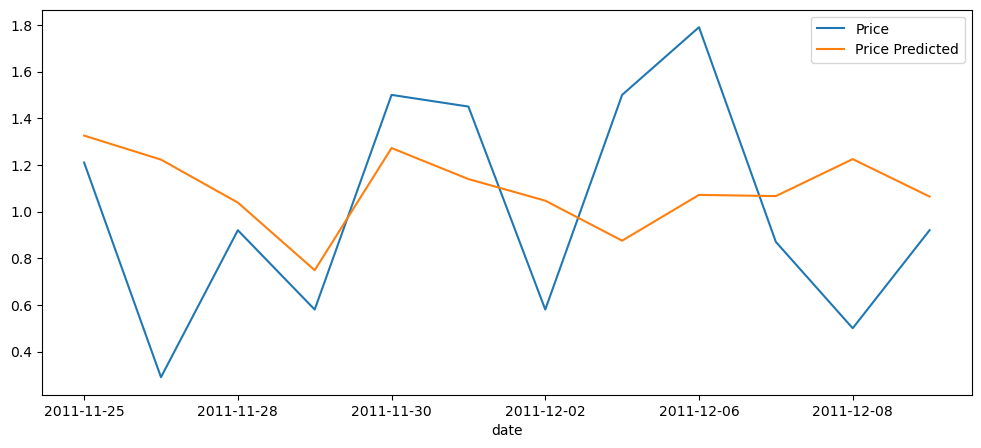

In [151]:
compare_df[['Price', 'Price Predicted']].plot(figsize=(12, 5))

<Axes: xlabel='date'>

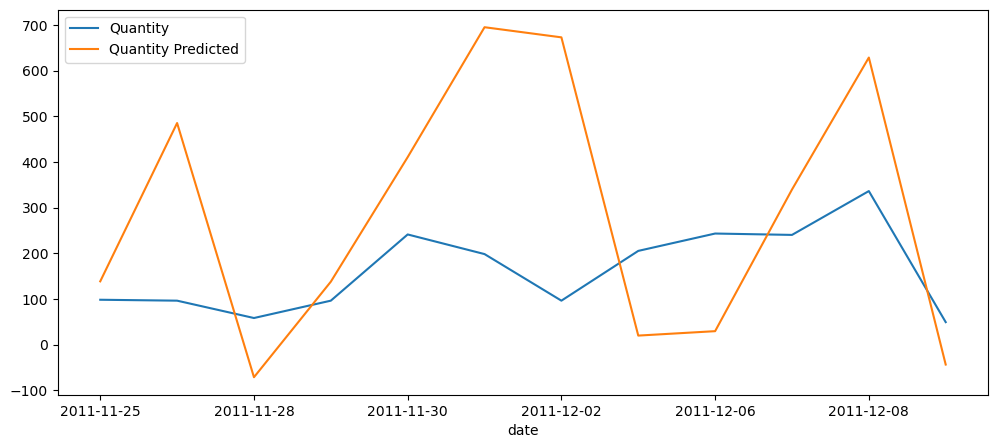

In [152]:
compare_df[['Quantity', 'Quantity Predicted']].plot(figsize=(12, 5))

In [156]:
rmse_price = math.sqrt(mean_squared_error(predictions['Price Predicted'], test_df['Price']))
print(f'Mean value of Price is : {np.mean(test_df["Price"])}. Root Mean Sqaure is: {rmse_price}')

rmse_quant = math.sqrt(mean_squared_error(predictions['Quantity Predicted'], test_df['Quantity']))
print(f'Mean value of Quantity is : {np.mean(test_df["Quantity"])}. Root Mean Sqaure is: {rmse_quant}')

Mean value of Price is : 1.0091666666666665. Root Mean Sqaure is: 0.4815955503107943
Mean value of Quantity is : 163.0. Root Mean Sqaure is: 283.3648760645836
